Training set: torch.Size([2222, 5]), Validation set: torch.Size([476, 5]), Test set: torch.Size([477, 5])
TempPredictor(
  (net): Sequential(
    (0): Linear(in_features=5, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)
Epoch 10/100, Train Loss: 0.0559, Val Loss: 0.0126
Epoch 20/100, Train Loss: 0.0521, Val Loss: 0.0097
Epoch 30/100, Train Loss: 0.0505, Val Loss: 0.0140
Epoch 40/100, Train Loss: 0.0491, Val Loss: 0.0096
Epoch 50/100, Train Loss: 0.0483, Val Loss: 0.0092
Epoch 60/100, Train Loss: 0.0478, Val Loss: 0.0109
Epoch 70/100, Train Loss: 0.0461, Val Loss: 0.0177
Epoch 80/100, Train Loss: 0.0446, Val Loss: 0.0088
Epoch 90/100, Train Loss: 0.0432, Val Loss: 0.0155
Epoch 100/100, Train Loss: 0.0430, Val Loss: 0.0109


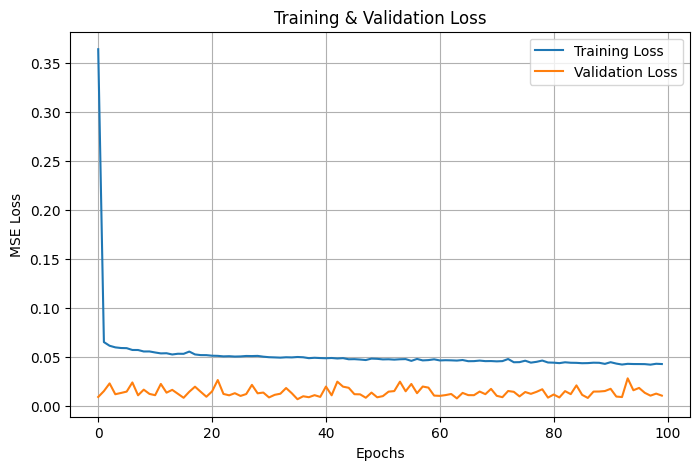

Test MSE Loss: 0.0421
Model and scalers saved successfully!


In [2]:
# 02_model_training.ipynb
# Task 2c, 2d, 2f: Model Configuration, Training, and Integration-ready Model

# --- Import libraries ---
import os
import sys
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import joblib

# Ensure project root in path
sys.path.append(os.path.abspath(".."))
from utils.data_loader import load_and_preprocess

# --- Load preprocessed data ---
X_train, X_val, X_test, y_train, y_val, y_test, scaler_X, scaler_y = load_and_preprocess(
    path='../data/raw_data.csv', lags=5
)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")

# --- Define the Model ---
class TempPredictor(nn.Module):
    def __init__(self, input_dim):
        super(TempPredictor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.net(x)

model = TempPredictor(input_dim=X_train.shape[1])
print(model)

# --- Define Loss and Optimizer ---
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# --- Prepare DataLoader ---
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# --- Training Loop ---
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    batch_train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        batch_train_loss += loss.item()
    train_losses.append(batch_train_loss / len(train_loader))
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for X_batch, y_batch in val_loader:
            y_pred = model(X_batch)
            val_loss += criterion(y_pred, y_batch).item()
    val_losses.append(val_loss / len(val_loader))
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

# --- Plot Training vs Validation Loss ---
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# --- Evaluate on Test Set ---
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test)
    test_loss = criterion(y_test_pred, y_test).item()
print(f"Test MSE Loss: {test_loss:.4f}")

# --- Save Model and Scalers ---
os.makedirs('../models', exist_ok=True)
torch.save(model.state_dict(), '../models/temp_predictor.pth')
joblib.dump(scaler_X, '../models/scaler_X.pkl')
joblib.dump(scaler_y, '../models/scaler_y.pkl')

print("Model and scalers saved successfully!")
